In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import joblib
import yaml

In [4]:
with open('data/dtypes_features.yaml','r') as dtf:
    dtypes = yaml.safe_load(dtf)


In [5]:
X_tr = pd.read_csv('train_test_data/X_tr.csv', dtype = dtypes)
y_tr = pd.read_csv('train_test_data/y_tr.csv')
X_te = pd.read_csv('train_test_data/X_te.csv', dtype = dtypes)
y_te = pd.read_csv('train_test_data/y_te.csv')

# Logistic model

In [6]:
# modules needed for logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, MinMaxScaler, KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import log_loss, make_scorer,  roc_auc_score
#
logistic_model = joblib.load('saved_models/logistic_model.joblib').best_estimator_


## Feature importance logistic

In [7]:
feature_transformer = logistic_model.named_steps['feature_transformer']
logistic_regression = logistic_model.named_steps['logistic_regression']

In [8]:
coef = logistic_regression.coef_

In [9]:
X_tr1 = pd.DataFrame(data = feature_transformer.transform(X_tr), columns = feature_transformer.get_feature_names_out())


In [10]:
coef_df = pd.DataFrame.from_dict(dict(feature_transformed = feature_transformer.get_feature_names_out(), 
                                      coef = logistic_regression.coef_.flatten()))
coef_df.insert(loc = 0,column='feature',value= coef_df['feature_transformed'].apply(lambda x:x.rstrip('_0123456789')))

In [11]:
coef_df

,feature,feature_transformed,coef
0,CHK_ACCT,CHK_ACCT_0,0.755869
1,CHK_ACCT,CHK_ACCT_1,0.195845
2,CHK_ACCT,CHK_ACCT_2,0.000000
3,CHK_ACCT,CHK_ACCT_3,-0.985282
4,DURATION,DURATION,0.403341
5,HISTORY,HISTORY_0,0.245102
6,HISTORY,HISTORY_1,0.421868
7,HISTORY,HISTORY_2,0.121513
8,HISTORY,HISTORY_3,-0.246247
9,HISTORY,HISTORY_4,-0.839003


## Logistic feature importance
Let $N$ be the number of rows. Feature $j$ contribution to an individual $i$ score is usually calculated $$\beta_jx_{i,j} - \frac{1}{N}\sum_{k=1}^N\beta_jx_{j,k}.$$ 
To get the feature over-all importance we take the absolute value of contributions and take the mean.

In [13]:
baseline = (coef*X_tr1).mean()
importance = pd.DataFrame(((coef*X_tr1) - baseline).abs().mean(0)).rename(columns = {0:'importance_transformed'})

In [14]:
coef_df1 = coef_df.merge(importance, left_on='feature_transformed',right_index = True)
coef_df2 = coef_df1.groupby(by='feature',as_index=False).sum()[['feature','importance_transformed']].rename(columns = {'importance_transformed':'importance'})
coef_df3 = coef_df1.merge(coef_df2,on='feature')

In [15]:
coef_df3.sort_values(by='coef',inplace = True,ascending = False)
coef_df3.sort_values(by='importance',inplace = True,ascending = False)

In [16]:
coef_df3.to_csv('saved_models/logistic_coef.csv')


# GBDT model

In [17]:
# Modules needed for tree-ensemble
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV
#
gbdt_model = joblib.load('saved_models/gbdt_model.joblib')
gbdt = gbdt_model.best_estimator_.calibrated_classifiers_[0].base_estimator



## GBDT feature importance

In [708]:
import shap

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


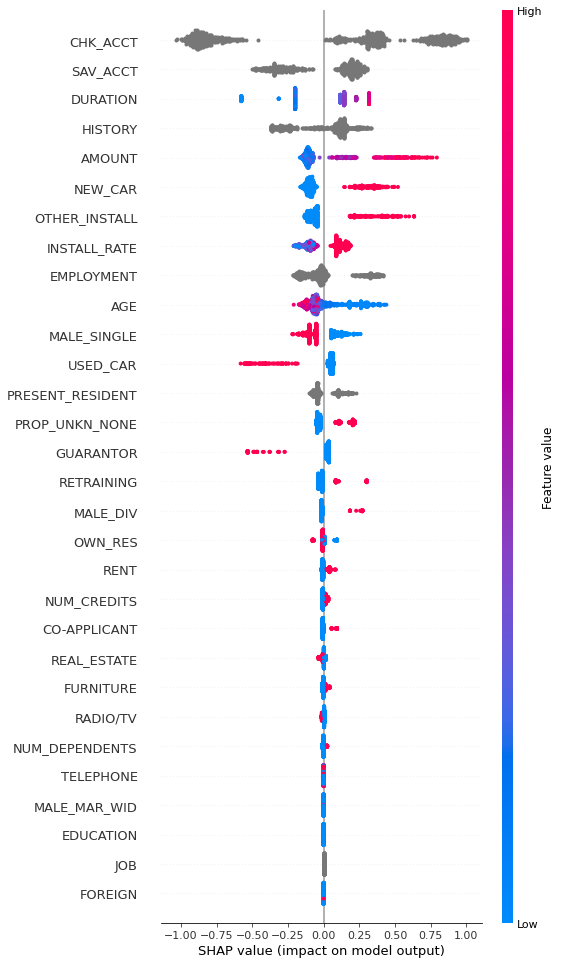

In [709]:
explainer = shap.TreeExplainer(gbdt)
shap_values = explainer.shap_values(X_tr)
shap.summary_plot(shap_values[1], X_tr,max_display=30)

# Scoring applications
Average out amount and duration variables to make a score that can run on applications.

In [18]:
def append_bg(x, background_dist,X_tr):
    x = x.copy()
    x.drop(columns = background_dist.columns, inplace =True)
    n_rep = background_dist.shape[0]
    newx = pd.DataFrame(np.repeat(x.values, n_rep, axis=0))
    newx.columns = x.columns
    newx = pd.concat([newx,background_dist],axis = 1)
    newx = newx.astype(X_tr.dtypes.to_dict())
    return newx[X_tr.columns]
    
    

In [561]:
score_df = pd.concat([X_te[['AMOUNT','DURATION']].copy(),y_te],axis=1)
score_df['GBDT_score_ad'] = np.nan
score_df['GBDT_score'] = np.nan
score_df['GBDT_score_d'] = np.nan

score_df['LR_score_ad'] = np.nan
score_df['LR_score'] = np.nan
score_df['LR_score_d'] = np.nan

In [565]:

background_dist = X_tr[['AMOUNT','DURATION']]

for i,_ in enumerate(X_te.iterrows()):
    x = X_te.iloc[i:i+1,:].copy()
    x_bg = append_bg(x,background_dist,X_tr)
    score_df.loc[i,'GBDT_score_ad'] = gbdt_model.predict_proba(x_bg)[:,1].mean(0)

In [566]:
background_dist = X_tr[['DURATION']]
for i,_ in enumerate(X_te.iterrows()):
    x = X_te.iloc[i:i+1,:].copy()
    x_bg = append_bg(x,background_dist,X_tr)
    score_df.loc[i,'GBDT_score_d'] = gbdt_model.predict_proba(x_bg)[:,1].mean(0)


In [567]:
for i,_ in enumerate(X_te.iterrows()):
    x = X_te.iloc[i:i+1,:].copy()
    score_df.loc[i,'GBDT_score'] = gbdt_model.predict_proba(x)[:,1].mean(0)

In [563]:
background_dist = X_tr[['AMOUNT','DURATION']]

for i,_ in enumerate(X_te.iterrows()):
    x = X_te.iloc[i:i+1,:].copy()
    x_bg = append_bg(x,background_dist,X_tr)
    score_df.loc[i,'LR_score_ad'] = logistic_model.predict_proba(x_bg)[:,1].mean(0)
    
background_dist = X_tr[['DURATION']]
for i,_ in enumerate(X_te.iterrows()):
    x = X_te.iloc[i:i+1,:].copy()
    x_bg = append_bg(x,background_dist,X_tr)
    score_df.loc[i,'LR_score_d'] = logistic_model.predict_proba(x_bg)[:,1].mean(0)

for i,_ in enumerate(X_te.iterrows()):
    x = X_te.iloc[i:i+1,:].copy()
    score_df.loc[i,'LR_score'] = logistic_model.predict_proba(x)[:,1].mean(0)

In [518]:
x = X_te.iloc[9:10,].copy()
x.drop(columns = ['AMOUNT','DURATION'], inplace =True)
x_bg = append_bg(x,background_dist,X_tr)
print(gbdt_model.predict_proba(x_bg)[:,1].mean(0))
print(logistic_model.predict_proba(x_bg)[:,1].mean(0))

0.49236164199603566
0.5664463370928601


In [568]:
score_df.to_csv('metrics_and_scores/rics_and_scores/test_scores.csv')

In [600]:
def t_auc_scores(score_df,score_col,y_col = 'DEFAULT',t_col = 'DURATION'):
    
    t_df = score_df.groupby(t_col,as_index = False).size().sort_values(by= t_col)
    ts = list(t_df[t_col].sort_values())
    t_df['auc_t']=np.nan
    for t in ts:
        if int(t_df.loc[t_df[t_col]==t,'size']) >10:
            df = score_df[score_df[t_col]==t]
            y_true = df[y_col]
            y_score = df[score_col]
            t_df.loc[t_df[t_col]==t,'auc_t'] = roc_auc_score(y_score = y_score, y_true = y_true)
    return t_df
t_auc_scores(score_df,'GBDT_score_ad').to_csv('metrics_and_scores/t_auc_GBDT_score_ad.csv')
t_auc_scores(score_df,'GBDT_score_d').to_csv('metrics_and_scores/t_auc_GBDT_score_d.csv')
t_auc_scores(score_df,'LR_score_ad').to_csv('metrics_and_scores/t_auc_LR_score_ad.csv')
t_auc_scores(score_df,'LR_score_d').to_csv('metrics_and_scores/t_auc_LR_score_d.csv')

# Plots

## Survival curves

In [733]:
X_subset =  X_te[X_te['DURATION']<=24]
y_subset = y_te[X_te['DURATION']<=24]
X_subset0 = X_subset[(y_subset==0)['DEFAULT']]
X_subset1 = X_subset[(y_subset==1)['DEFAULT']]

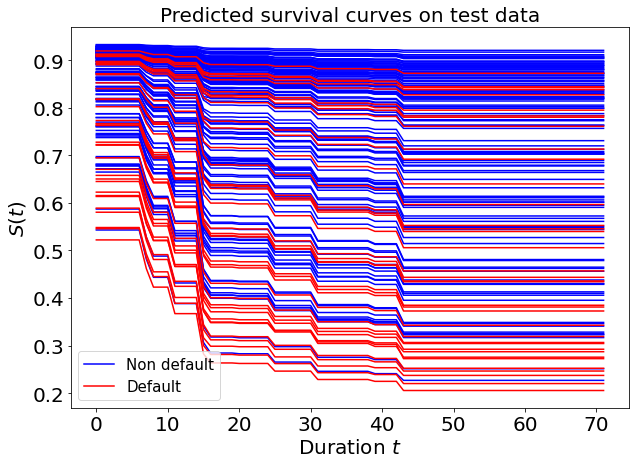

In [738]:
f,ax= plt.subplots(figsize = (10,7))
for j in range(X_subset0.shape[0]):
    one_record = pd.concat([X_subset0.iloc[j:j+1,:].copy() for i in range(1,73)],
                           axis = 0)
    one_record['DURATION'] = range(1,73)
    if j==0:
        ax.plot(1-gbdt_model.predict_proba(one_record)[:,1],color='b',label = 'Non default')
    else:
        ax.plot(1-gbdt_model.predict_proba(one_record)[:,1],color='b')
for j in range(X_subset1.shape[0]):
    one_record = pd.concat([X_subset1.iloc[j:j+1,:].copy() for i in range(1,73)],
                           axis = 0)
    one_record['DURATION'] = range(1,73)
    if j==0:
        ax.plot(1-gbdt_model.predict_proba(one_record)[:,1],color='r',label = 'Default')
    else:
        ax.plot(1-gbdt_model.predict_proba(one_record)[:,1],color='r')

ax.tick_params(axis = 'both',labelsize = 20)
ax.set_xlabel('Duration $t$',fontsize =20)
ax.set_ylabel('$S(t)$',fontsize=20)
ax.set_title('Predicted survival curves on test data',fontsize = 20)
ax.legend(fontsize=15)

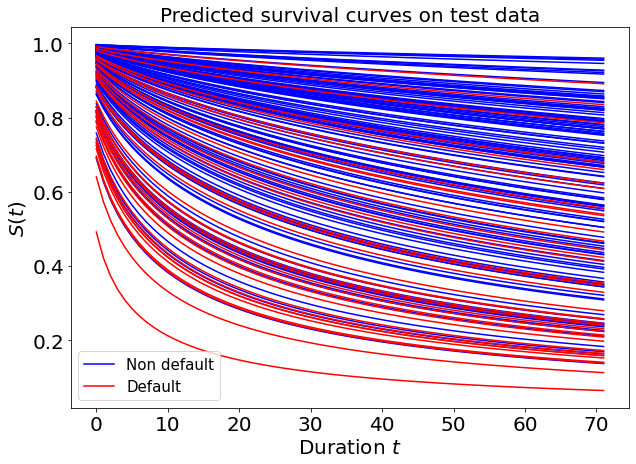

In [737]:
f,ax= plt.subplots(figsize = (10,7))
for j in range(X_subset0.shape[0]):
    one_record = pd.concat([X_subset0.iloc[j:j+1,:].copy() for i in range(1,73)],
                           axis = 0)
    one_record['DURATION'] = range(1,73)
    if j==0:
        ax.plot(1-logistic_model.predict_proba(one_record)[:,1],color='b',label = 'Non default')
    else:
        ax.plot(1-logistic_model.predict_proba(one_record)[:,1],color='b')
for j in range(X_subset1.shape[0]):
    one_record = pd.concat([X_subset1.iloc[j:j+1,:].copy() for i in range(1,73)],
                           axis = 0)
    one_record['DURATION'] = range(1,73)
    if j==0:
        ax.plot(1-logistic_model.predict_proba(one_record)[:,1],color='r',label = 'Default')
    else:
        ax.plot(1-logistic_model.predict_proba(one_record)[:,1],color='r')

ax.tick_params(axis = 'both',labelsize = 20)
ax.set_xlabel('Duration $t$',fontsize =20)
ax.set_ylabel('$S(t)$',fontsize=20)
ax.set_title('Predicted survival curves on test data',fontsize = 20)
ax.legend(fontsize=15)

In [793]:
j = 0
one_record = pd.concat([X_subset1.iloc[j:j+1,:].copy() for i in range(10000)],
                           axis = 0)

one_record[['DURATION','AMOUNT']] = [[x,y] for x in np.linspace(X_tr.DURATION.min(),X_tr.DURATION.max(),100) 
                                     for y in np.linspace(X_tr.AMOUNT.min(),X_tr.AMOUNT.max(),100)]


## Amount x Duration - > default risk heatmaps


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(42.0, 0.5, 'Duration $t$')

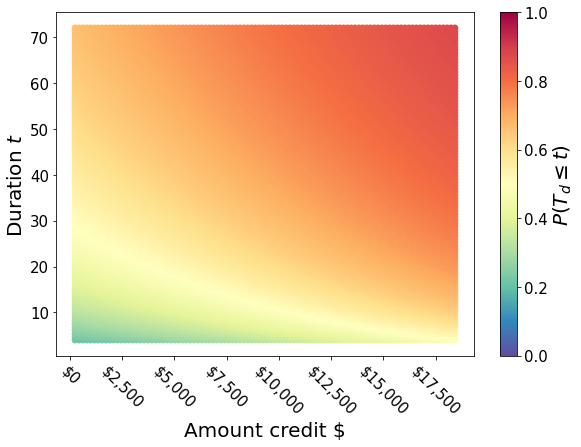

In [794]:
sample_data = one_record[['AMOUNT','DURATION']]
sample_data['P_default'] = logistic_model.predict_proba(one_record)[:,1]
f = plt.figure(figsize = (8,6))
plt.scatter(sample_data.AMOUNT,sample_data.DURATION,c=sample_data.P_default,cmap = 'Spectral_r')
cbar = plt.colorbar()
cbar.set_label('$P(T_d\leq t)$',fontsize = 20)
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
f.get_axes()[0].xaxis.set_major_formatter(tick)
f.get_axes()[0].tick_params('both',labelsize = 15)
f.get_axes()[0].tick_params('x',labelrotation = -45)
f.get_axes()[1].tick_params('both',labelsize = 15)
plt.clim(0.,1.)
plt.tight_layout()
f.get_axes()[0].set_xlabel('Amount credit $',fontsize = 20)
f.get_axes()[0].set_ylabel('Duration $t$',fontsize = 20)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(42.0, 0.5, 'Duration $t$')

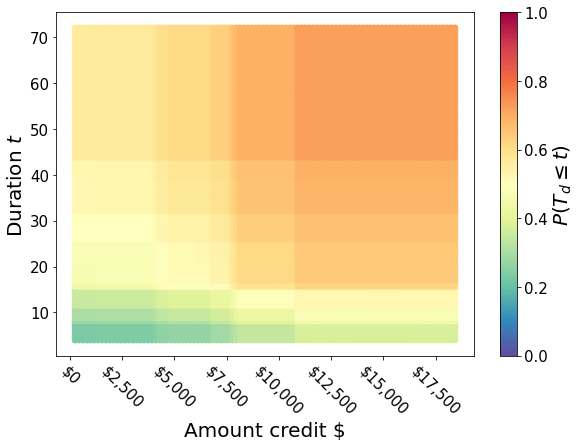

In [795]:
sample_data = one_record[['AMOUNT','DURATION']]
sample_data['P_default2'] = gbdt_model.predict_proba(one_record)[:,1]

f = plt.figure(figsize = (8,6))
plt.scatter(sample_data.AMOUNT,sample_data.DURATION,c=sample_data.P_default2,cmap = 'Spectral_r')
cbar = plt.colorbar()
cbar.set_label('$P(T_d\leq t)$',fontsize = 20)
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
f.get_axes()[0].xaxis.set_major_formatter(tick)
f.get_axes()[0].tick_params('both',labelsize = 15)
f.get_axes()[0].tick_params('x',labelrotation = -45)
f.get_axes()[1].tick_params('both',labelsize = 15)
plt.clim(0.,1.)
plt.tight_layout()
f.get_axes()[0].set_xlabel('Amount credit $',fontsize = 20)
f.get_axes()[0].set_ylabel('Duration $t$',fontsize = 20)


# Exploration: Default rate varying over time

In [19]:
X = pd.concat([X_tr,X_te],axis=0)
y = pd.concat([y_tr,y_te],axis=0)

C:\Users\cassi\Anaconda3\envs\python3.10\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\cassi\Anaconda3\envs\python3.10\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


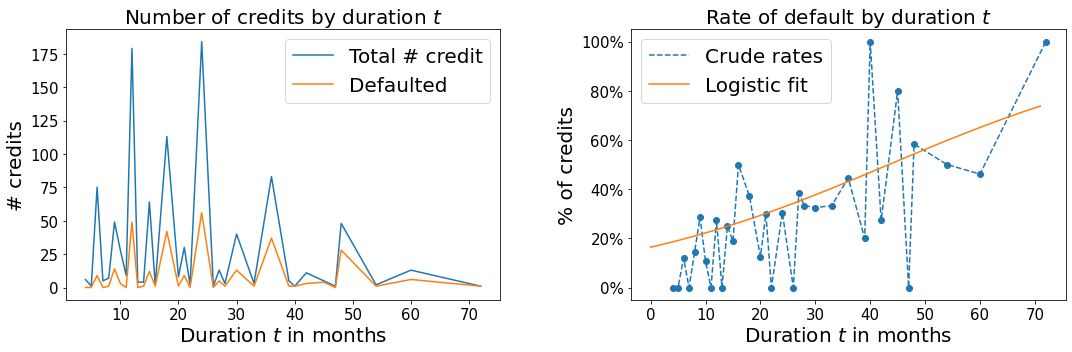

In [27]:
from sklearn.preprocessing import StandardScaler
f,ax = plt.subplots(1,2,figsize = (15,5))
import matplotlib.ticker as mtick
time_data = pd.DataFrame(X.iloc[list(np.array(y)==1),:].groupby('DURATION').size()).rename(columns = {0:'Defaulted'}).merge(
    pd.DataFrame(X.iloc[list(np.array(y)==0),:].groupby('DURATION').size()).rename(columns = {0:'Did not default'}),left_index=True,right_index=True,
how='outer').fillna(0)
time_data['Total # credit'] = time_data.Defaulted + time_data['Did not default']
time_data[['Total # credit','Defaulted']].plot(ax=ax[0])
td = (100*time_data.div(time_data[['Did not default','Defaulted']].sum(1),axis=0))
ax[1].scatter(list(td.index),td['Defaulted'])
ax[1].plot(list(td.index),td['Defaulted'],linestyle = '--', label = 'Crude rates')
lr = LogisticRegression(C=1E30)
lr.fit(X[['DURATION']],y)
ax[1].plot(100*lr.predict_proba(np.arange(1,73).reshape(-1,1))[:,1],label= 'Logistic fit')
ax[0].set_xlabel('Duration $t$ in months',fontsize= 20)
ax[1].set_xlabel('Duration $t$ in months',fontsize= 20)
ax[0].tick_params(axis = 'both',labelsize=15)
ax[1].tick_params(axis = 'both',labelsize=15)
ax[0].set_ylabel('# credits',fontsize= 20)
ax[0].set_title('Number of credits by duration $t$',fontsize=20)
ax[1].set_title('Rate of default by duration $t$',fontsize = 20)
ax[1].set_ylabel('% of credits',fontsize= 20)
ax[0].legend(prop={'size': 20})
ax[1].legend(prop={'size': 20})

ax[1].yaxis.set_major_formatter(mtick.PercentFormatter())
f.tight_layout()
f.subplots_adjust(wspace=.3)

C:\Users\cassi\Anaconda3\envs\python3.10\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\cassi\Anaconda3\envs\python3.10\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


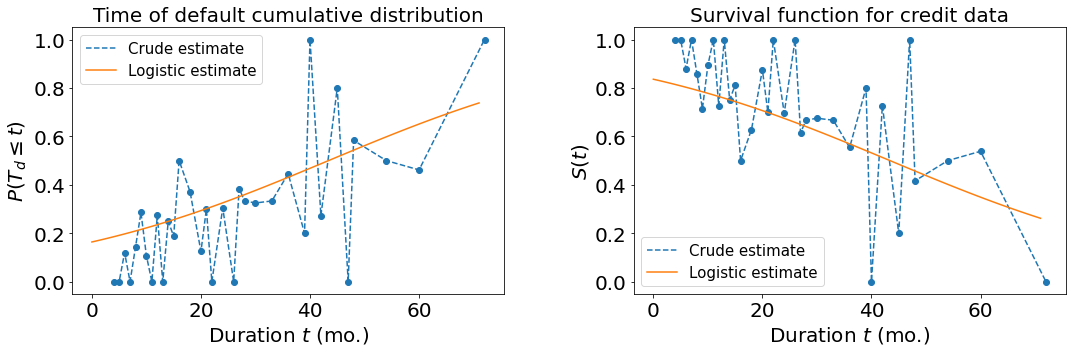

In [39]:
f,ax = plt.subplots(1,2,figsize = (15,5))
td = (time_data.div(time_data[['Did not default','Defaulted']].sum(1),axis=0))

ax[1].plot(1-td[['Defaulted']],linestyle = '--',label = 'Crude estimate')
ax[1].scatter(list(td.index),1-td['Defaulted'])
ax[1].plot(1-lr.predict_proba(np.arange(1,73).reshape(-1,1))[:,1],label= 'Logistic estimate')

ax[0].plot(td[['Defaulted']],linestyle = '--',label = 'Crude estimate')
ax[0].scatter(list(td.index),td['Defaulted'])
ax[0].plot(lr.predict_proba(np.arange(1,73).reshape(-1,1))[:,1],label= 'Logistic estimate')



ax[0].legend(fontsize = 15)
ax[0].set_xlabel('Duration $t$ (mo.)',fontsize= 20)
ax[0].tick_params(axis = 'both', labelsize = 20)
ax[0].set_ylabel('$P(T_d\leq t)$',fontsize= 20)
ax[0].set_title('Time of default cumulative distribution',fontsize = 20)

ax[1].legend(fontsize = 15)
ax[1].set_xlabel('Duration $t$ (mo.)',fontsize= 20)
ax[1].tick_params(axis = 'both', labelsize = 20)
ax[1].set_ylabel('$S(t)$',fontsize= 20)
ax[1].set_title('Survival function for credit data',fontsize = 20)
f.tight_layout()
f.subplots_adjust(wspace=.3)